In [4]:
# Enable fullscreen

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [5]:
import numpy as np
from matplotlib import pyplot as pl
import os
import scipy.io.wavfile as wav

%matplotlib inline

In [6]:
PATH = './vowels/vowels/'

### file name format:
* n = natural
* s = synthetic
* a = adult
* m = male
* f = female



In [7]:
from python_speech_features import mfcc

## 1. Man vs Woman. Use only the natural voices of men and women to train a neural network that recognizes the gender of the speaker. 

72  elements have been read
nafsher.wav [1]
nafdlii.wav [1]
namcrer.wav [-1]
namphul.wav [-1]


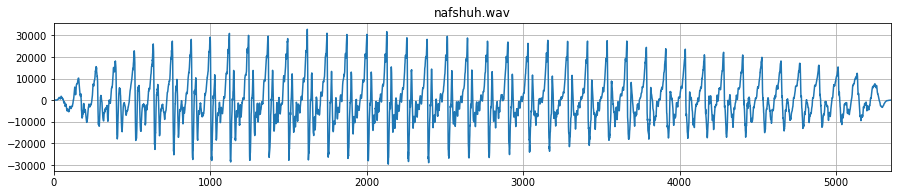

In [70]:
# Read all files starting with a pattern
def readFiles(pattern):
    sounds = []
    for file in os.scandir(PATH):
        if file.name.startswith(pattern):
            sample_rate, signal = wav.read(os.path.join(PATH, file.name))
            sound_class = [1] if file.name.startswith(pattern + 'f') else [-1]
            sounds.append((sample_rate, signal, file.name, sound_class))
            
    print(len(sounds), ' elements have been read')
    return sounds

# Plot one sound (signal) with its pretty name
def plotSound(signal, name):
    pl.figure(figsize=(15,6))
    pl.subplot(2,1,1)
    pl.plot(signal)
    pl.xlim(0, len(signal))
    pl.title(name)
    pl.grid()

sounds = readFiles('na')

# Let's test if the read worked...
plotSound(sounds[0][1], sounds[0][2])

# Here we print the filename and the class. We chose Female=1 and Male=-1
for sound in sounds[4:8]:
    print(sound[2], sound[3])

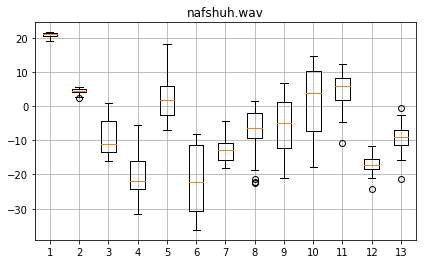

In [71]:
def doMFCC(signal, sample_rate):
    ceps = mfcc(signal, samplerate=sample_rate, nfft=1024)
    return ceps

def plotBoxSound(ceps, name):
    pl.figure(figsize=(15,4))
    pl.subplot(1,2,1)
    pl.boxplot(ceps)
    pl.title(name)
    pl.grid()
    
ceps_data = list(map(lambda s: doMFCC(s[1], s[0]) , sounds))

# List of all file names
ceps_names = list(map(lambda s: s[2] , sounds))

# List of all class
ceps_class = list(map(lambda s: s[3] , sounds))


# Some boxplot
plotBoxSound(ceps_data[0], ceps_names[0])

In [72]:
# We noramlize the data
def normalizeOne(array):
    return list(map(lambda s: np.median(s, axis=0), array))

normalized_ceps_data = normalizeOne(ceps_data)

In [89]:
import pandas as pd

dataset = np.hstack((np.array(ceps_class), np.array(normalized_ceps_data)))

cols = np.array([
    'class','1', '2', '3', '4', '5', '6','7', 
    '8', '9', '10', '11', '12',
    '13',
])

df = pd.DataFrame(data=dataset, columns=cols, index=ceps_names)
df

,class,1,2,3,4,5,6,7,8,9,10,11,12,13
nafshuh.wav,1.0,21.180573,4.528596,-11.084089,-22.021199,1.631916,-22.151740,-12.924492,-6.338638,-5.051009,3.907463,5.820312,-17.150064,-8.910504
nafshoo.wav,1.0,20.641041,7.094395,0.645532,-24.869709,7.324858,-19.564769,-11.496958,-22.141888,-9.233627,-2.417076,8.987575,-4.036404,1.554718
namshul.wav,-1.0,21.081440,-2.098263,2.736653,-14.816751,3.075080,-15.325842,-13.777212,6.032944,-39.724345,-2.018744,6.114316,12.711576,6.864586
nafkguh.wav,1.0,21.127433,8.231642,-16.730288,-8.272131,-10.362072,-20.795418,5.850460,-13.493688,-0.416923,10.551215,-11.586354,-10.858448,-25.930500
nafsher.wav,1.0,20.643418,9.989729,6.525908,-36.925872,-4.701238,9.536004,-14.589698,-16.180714,-24.699344,-7.428072,27.910787,-25.519577,-5.498373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nampher.wav,-1.0,20.381754,14.445921,-6.488266,-21.433982,-0.471431,-8.282221,11.718249,-34.011880,-42.064944,23.079312,18.902747,-0.494506,-1.640150
namshuu.wav,-1.0,20.465224,-4.322017,17.707338,-0.385085,6.745050,-6.840979,-0.924333,16.622516,-54.390680,-21.320165,-8.351816,-10.378791,16.460746
nafkgal.wav,1.0,20.977937,8.310045,-19.367667,-7.767151,-5.583196,-11.348555,6.935630,-2.610862,5.004035,-5.582787,-22.998612,-6.334451,-26.940507
namshoo.wav,-1.0,20.468938,4.702123,4.750504,-23.709057,0.026083,-27.615887,1.149870,26.409252,-15.356378,-19.110937,5.571876,-6.617428,23.275449


## The MLP &  Cross-validation
Import the code of the backpropagation with momentum algorithm and the code of the cross-valdidation test

In [90]:
import mlp_backprop_momentum as mlp
import k_fold_cross_validation as cv

### Util functions

In [91]:
def split_dataset(dataset, n_parts=5):
    n_rows = dataset.shape[0]
    index_all = np.arange(n_rows)
    np.random.shuffle(index_all)
    parts = []
    current_start = 0
    for p in np.arange(n_parts):
        current_end = current_start + int(np.floor(n_rows / (n_parts-p)))
        parts.append(dataset[index_all[current_start:current_end],:])
        n_rows -= current_end - current_start
        current_start = current_end
    return parts

In [92]:
def k_fold_cross_validation(mlp, dataset, K=5, learning_rate=0.01, momentum=0.7, epochs=100):
    MSE_train_mean = 0.0
    MSE_test_mean = 0.0

    parts = split_dataset(dataset, K)
    
    for k in np.arange(K):
        mlp.init_weights()
        
        training_parts = set(np.arange(K))
        training_parts.remove(k)
        dataset_train = np.concatenate([parts[i] for i in list(training_parts)])
        dataset_test = parts[k]

        input_data = dataset_train[:,0:nn.n_inputs]
        output_data = dataset_train[:,nn.n_inputs:(nn.n_inputs+nn.n_outputs)]
        input_data_test = dataset_test[:,0:nn.n_inputs]
        output_data_test = dataset_test[:,nn.n_inputs:(nn.n_inputs+nn.n_outputs)]
        
        MSE_train = mlp.fit((input_data, output_data),
                            learning_rate=learning_rate, momentum=momentum, epochs=epochs)
        temp, _ = mlp.compute_MSE((input_data, output_data))
        MSE_train_mean += temp
        temp, _ = mlp.compute_MSE((input_data_test, output_data_test))
        MSE_test_mean += temp

    return (MSE_train_mean / K, MSE_test_mean / K)

## Experiment

### Configuration of the MLP

In [129]:
# Configuration

N_INITS = 10
EPOCHS = 120 # En gros, le nombre d'exécution
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001 # Pour la correction
MOMENTUM = 0.5 # On pousse la boule avec de l'élan

N_FEATURES = 13
ACTIVATION_FUNCTION = 'tanh'

In [130]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([N_FEATURES,h,1], ACTIVATION_FUNCTION)
    for i in np.arange(N_INITS):                                        # looping over the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataset[:,1:14], dataset[:,0:1]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)
        
print('Done :D')

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
Done :D


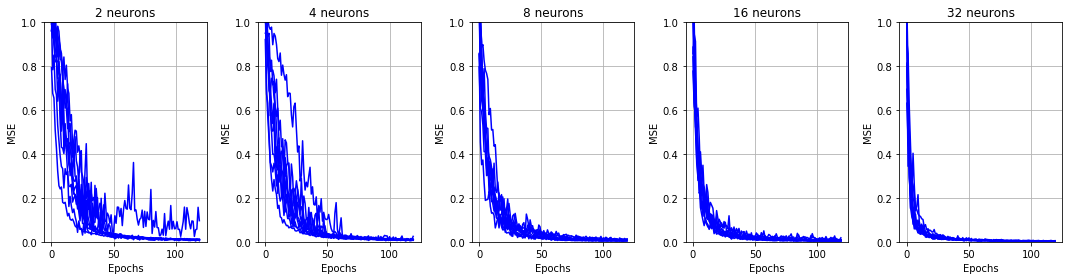

In [131]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()